In [1]:
### Import packages

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette("Dark2")

from learnspec.functions import directories, stacking

import pandas as pd

### For ML
import tensorflow as tf
from tensorflow.keras import layers, Model

### Enforce full precision when using GPUs
# tf.keras.backend.set_floatx('float32')


plt.style.use('/Users/aayushsaxena/Desktop/Oxford/plt_styles/as_jades.mplstyle')


In [ ]:
### List of all input redshift catalogues
all_redshifts = ["/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-DEEP/visual_inspection_hst_gs_deep_v0.7.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-1287/visual_redshifts_consolidated_1287_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-3215/visual_redshifts_consolidated_ultra_deep_gs_3215_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-MEDIUM/visual_redshifts_hst_medium_redo_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1180/visual_redshifts_JWST_Medium_1180_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1286/visual_redshifts_1286_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-HST-MEDIUM/visual_redshifts_consolidated_gn_hst_medium_1181_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-JWST-MEDIUM/visual_redshifts_consolidated_gn_jwst_medium_1181_v0.6.csv"]

all_surveys = ['GS-HST-DEEP', 'GS-JWST-DEEP', 'GS-3215', 'GS-HST-MEDIUM', 'GS-JWST-MEDIUM-1180', 'GS-JWST-MEDIUM-1286', 'GN-HST-MEDIUM', 'GN-JWST-MEDIUM']

# Pre-processing of the data

In [ ]:
### It is possible to load in multiple redshift catalogues and combine them
### This is useful if you want to stack sources from multiple surveys
grating = "prism"

speclist = []
redshifts = []
for i in range(len(all_redshifts)):
    input_cat = pd.read_csv(all_redshifts[i])
    survey = all_surveys[i]
    redshift_range = (6,15)
    specdir, version = directories.translate_dir(survey, grating)
    speclist_temp, redshifts_temp = directories.select_sources(input_cat, specdir, redshift_range, grating, version)
    speclist.extend(speclist_temp)
    redshifts.extend(redshifts_temp)

redshifts = np.array(redshifts, dtype=float)
total_sources = len(speclist)
print(f"Number of sources with z > {redshift_range[0]} and z < {redshift_range[1]}: {total_sources}")

In [ ]:
# First step is to de-redshift, renormalize and resample all the spectra on to a common wavelength grid
# The renormalization for the majority of the spectra is done such that the flux at 1500A rest frame is set to 1
# For grating spectra, currently no renormalization is done
# Pick the desired resolution of the final stack
resolution = 3.0

if grating == 'prism':
    mean_stack, median_stack, std_stack, resampled_spec = stacking.sigma_clipped_stacking(speclist, redshifts, resolution=resolution, sigma=100.0)
    # mean_stack, resampled_spec = stacking.mean_stacking(speclist, redshifts, resolution=resolution)
else:
    mean_stack, median_stack, std_stack, resampled_spec = stacking.stack_grating(speclist, redshifts, grating=grating, resolution=resolution)


print("Spectra de-redshifted, renormalized and resampled")
print("Mean stack shape: ", mean_stack.shape)
print("Median redshift: ", np.median(redshifts))


In [ ]:
### Plot resampled spectra
plt.figure(figsize=(10, 6))
for i in range(len(resampled_spec)):
    plt.plot(resampled_spec[i].spectral_axis, resampled_spec[i].data, alpha=0.2, color='grey')


plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.ylim(-0.5, 2.5)
plt.show()

## Dimensionality reduction and clustering analysis on resampled spectra

### Pre-processing the data

In [4]:
### Load resampled spectra
original_resampled_data = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/dja_z4-16/dja_resampled_spectra_z4-16.npy")
### Create a copy of the original resampled data
resampled_data = np.copy(original_resampled_data)

### Load the wavelength grid
wavelength = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/dja_z4-16/dja_resampled_wavelength_z4-16.npy")
### Load the redshift information
redshifts = np.load("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/data/dja_z4-16/dja_redshift_info_z4-16.npy")

### Let's remove NaN values from the spectra by setting them to 0
for i in range(len(resampled_data)):
    resampled_data[i][np.isnan(resampled_data[i])] = 0.0
    resampled_data[i][np.isinf(resampled_data[i])] = 0.0

### Print the total number of spectra
total_sources = len(resampled_data)
print(f"Number of sources: {total_sources}")

Number of sources: 3751


In [3]:
### Attempt to de-noise the spectra using Gaussian smoothing
from scipy.ndimage import gaussian_filter1d

resampled_data = gaussian_filter1d(resampled_data, sigma=1.5, axis=1)

In [5]:
### Piecewise smoothing based on wavelength

### Find nearest wavelength index
def find_nearest_index(wavelengths, target_wavelength):
    return np.abs(wavelengths - target_wavelength).argmin()

def piecewise_smooth_spectrum(spectrum, wavelengths):
    smoothed = np.zeros_like(spectrum)
    
    # Define regions and corresponding sigmas
    idx3000 = find_nearest_index(wavelengths, 3000)
    idx6000 = find_nearest_index(wavelengths, 6000)

    smoothed[:idx3000] = gaussian_filter1d(spectrum[:idx3000], sigma=2.0)
    smoothed[idx3000:idx6000] = gaussian_filter1d(spectrum[idx3000:idx6000], sigma=1.5)
    smoothed[idx6000:] = gaussian_filter1d(spectrum[idx6000:], sigma=1.0)

    return smoothed
# Apply the piecewise smoothing function to each spectrum
resampled_data = np.array([piecewise_smooth_spectrum(spec, wavelength) for spec in resampled_data])

In [6]:

### Extract the wavelength axis from the first spectrum
# wavelength = resampled_spec[0].spectral_axis.value

### Furthermore, let's minmax normalize the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Also try and standardize the data instead
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### To preserve the emission line features, we can also use the RobustScaler
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# resampled_data = scaler.fit_transform(resampled_data)

### Implement arcsinh transformation, which is good for spectra that have strong emission lines
from sklearn.preprocessing import FunctionTransformer
arcsinh_transformer = FunctionTransformer(np.arcsinh, validate=True)
scale_factor = 1.
resampled_data = arcsinh_transformer.fit_transform(resampled_data)/scale_factor

### Save the transformed data for later use
# np.save("../data/resampled_data_z4_16_res2.npy", resampled_data)
# ## Save the corresponding wavelength axis
# np.save("../data/wavelength_z4_16_res2.npy", resampled_spec[0].spectral_axis.value)
# ## Save the redshift values
# np.save("../data/redshift_z4_16_res2.npy", redshifts)

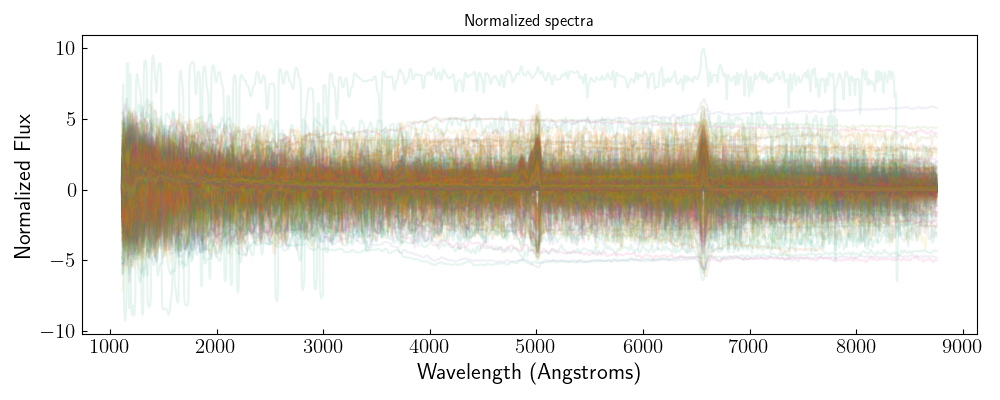

In [7]:
### Plot the normalized data
plt.close()
plt.figure(figsize=(10,4))
### Plot all spectra
plt.plot(wavelength, resampled_data.T, alpha=0.1)
### Only plot spectra with prominent negative values
# plt.plot(wavelength, spectra_denoised.T, alpha=0.1)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Normalized Flux")
plt.title("Normalized spectra")
plt.tight_layout()
plt.show()

In [8]:
### Print the summary statistics of the data
print(np.min(resampled_data), np.max(resampled_data), np.mean(resampled_data), np.std(resampled_data))

-9.257771786338237 9.984737390250583 0.22412487570747636 0.521161424363753


In [9]:
### Identify spectra that may have negative values

def detect_negative_spikes(spectra, threshold=-2.0, prominence=0.5):
    """Flag spectra with strong negative fluxes in arcsinh-transformed data."""
    flagged = []
    for i, spec in enumerate(spectra):
        # Focus only on values that deviate significantly below median
        median = np.median(spec)
        min_flux = np.min(spec)
        if (min_flux - median) < threshold and abs(min_flux - median) > prominence:
            flagged.append(i)
    return flagged

flagged_indices = detect_negative_spikes(resampled_data)
print(f"Number of flagged spectra: {len(flagged_indices)}")



Number of flagged spectra: 438


In [10]:
### Prepare the data for the VAE
# Set input dimensions
input_dim = len(resampled_data[0])  # Change this to your spectral length
print(f"Input dimension: {input_dim}")
latent_dim = 16  # Change this to your desired latent dimension

Input dimension: 2548


In [11]:
# === Encoder ===
inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === Decoder ===
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)  # use linear activation for reconstruction

decoder = Model(latent_inputs, outputs, name="decoder")

# === Custom VAE Model ===
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # === Masking regions where data == 0 (i.e., formerly NaN) ===
            mask = tf.cast(tf.not_equal(data, 0.0), tf.float32)
            diff = mask * (data - reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(diff), axis=1))

            # KL divergence (safe)
            z_log_var_clipped = tf.clip_by_value(z_log_var, -10.0, 10.0)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var_clipped - tf.square(z_mean) - tf.exp(z_log_var_clipped), axis=1
            ))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

# === Compile and Train ===
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))


In [12]:
### Training the model
vae.fit(resampled_data, epochs=500, batch_size=128, shuffle=True)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - kl_loss: 4.7559 - loss: 893.4780 - reconstruction_loss: 888.7221
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 16.1068 - loss: 601.6240 - reconstruction_loss: 585.5172
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 16.2790 - loss: 415.1192 - reconstruction_loss: 398.8402
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 22.8130 - loss: 419.0565 - reconstruction_loss: 396.2435
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 25.3308 - loss: 318.0666 - reconstruction_loss: 292.7358
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 21.8899 - loss: 287.4595 - reconstruction_loss: 265.5695
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 20.9848 - loss: 299.7452 - reconstruction_loss: 278.7604
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 20.1339 - loss: 293.3086 - reconstruction_loss: 273.1746
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s

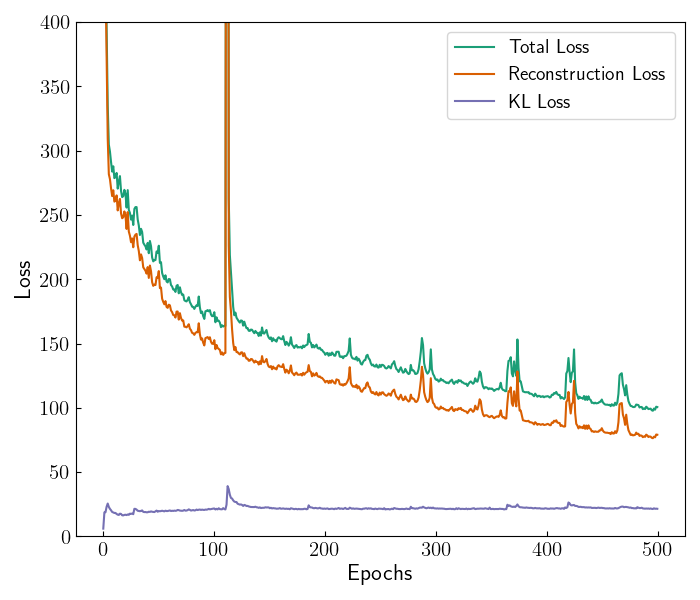

In [13]:
### Keep track of final validation loss at the end of training
history = vae.history.history
loss = history['loss']
reconstruction_loss = history['reconstruction_loss']
kl_loss = history['kl_loss']

# final_loss_8dim = loss[-1]

### Plot the training loss
plt.close()
plt.figure(figsize=(7, 6))
plt.plot(loss, label='Total Loss')
plt.plot(reconstruction_loss, label='Reconstruction Loss')
plt.plot(kl_loss, label='KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 400)
plt.legend(fontsize=14)
# plt.title('VAE Training Loss')
plt.tight_layout()
# plt.savefig("vae_training_loss.png", dpi=300)
plt.show()

In [ ]:
### Save the model weights
vae.build(input_shape=(None, input_dim))
vae.save_weights("dja_z4_16_res3_dim16_vae_model.weights.h5")
### Load the model weights
# vae.load_weights("../model/jades_z4_16_res3_vae_model.weights.h5")

In [264]:
### Save the full model in keras format
vae.save("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/models/dja_z4_16_res3_dim16_vae_model_full.keras")  # TensorFlow's recommended format
### Save the model in hdf5 format
# vae.save("../model/jades_z4_16_res3_vae_model_full.h5")  # HDF5 format

### Load the model
# from tensorflow.keras.models import load_model
# vae = tf.keras.models.load_model("/Users/aayushsaxena/Desktop/Oxford/scripts/learnspec/models/jades_z4_16_res3_vae_model_full.keras", 
#                                  custom_objects={'VAE': VAE, 'sampling': sampling})
### Load the model
# vae = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_model_full.h5", custom_objects={'sampling': sampling})


In [265]:
### Save the encoder and decoder separately
encoder.save("../models/dja_z4_16_res3_dim16_vae_encoder.keras")
decoder.save("../models/dja_z4_16_res3_dim16_vae_decoder.keras")
### Load the encoder and decoder separately
# encoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_encoder.keras", custom_objects={'sampling': sampling})
# decoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_decoder.keras", custom_objects={'sampling': sampling})

### Save the encoder and decoder separately in hdf5 format
# encoder.save("../models/jades_z4_16_res3_vae_encoder.h5")
# decoder.save("../models/jades_z4_16_res3_vae_decoder.h5")
### Load the encoder and decoder separately in hdf5 format
# encoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_encoder.h5", custom_objects={'sampling': sampling})
# decoder = tf.keras.models.load_model("../model/jades_z4_16_res3_vae_decoder.h5", custom_objects={'sampling': sampling})

## Predict the spectra for our own data

In [14]:
### Extract the latent space representation
z_mean, z_log_var, z = encoder.predict(resampled_data)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


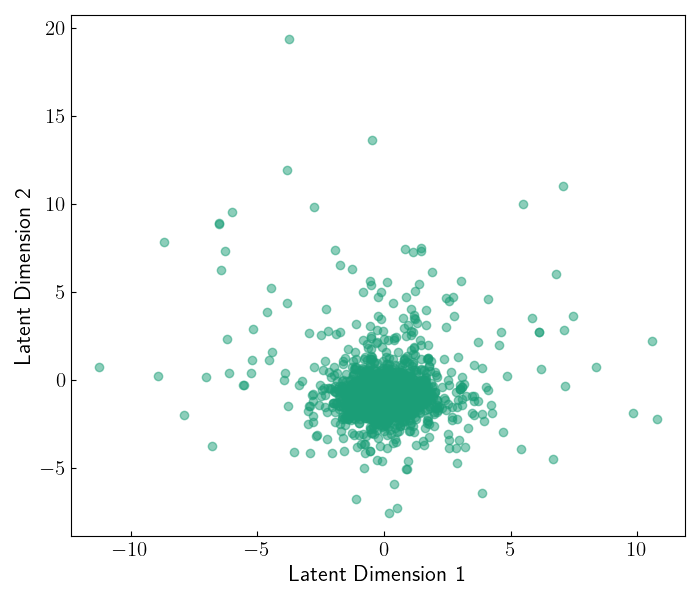

In [15]:
### Visualize the latent space
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
# plt.title("Latent Space Representation")
plt.tight_layout()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


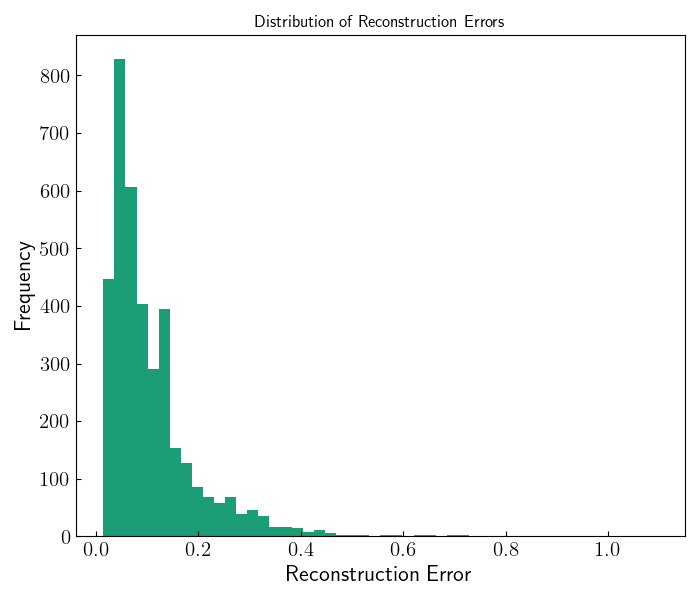

In [16]:
### Reconstruction errors
# Compute reconstruction errors
reconstructed_spectra = vae.decoder.predict(z_mean)
reconstruction_errors = np.mean(np.abs(resampled_data - reconstructed_spectra), axis=1)

# Plot reconstruction errors
plt.close()
plt.figure(figsize=(7, 6))
plt.hist(reconstruction_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.tight_layout()
# plt.savefig("reconstruction_errors.png", dpi=300)
plt.show()


Sample index: 1308
Reconstruction error: 0.061181919061356484


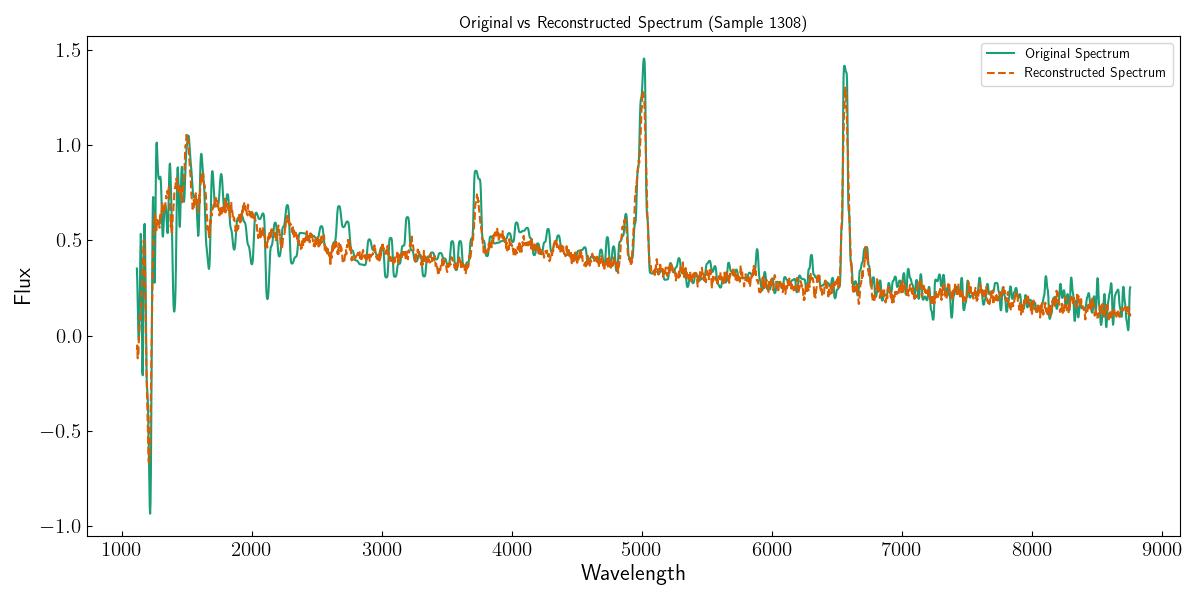

In [21]:
### Visualize specific spectra
# Select a random sample from the data
sample_idx = np.random.randint(len(resampled_data))

# Visualise the source with the second highest reconstruction error
# sample_idx = np.argmax(reconstruction_errors)
# sample_idx = np.argsort(reconstruction_errors)[-13]

### POick the sample spectrum and its corresponding reconstructed spectrum
sample_spectrum = resampled_data[sample_idx]
reconstructed_spectrum = reconstructed_spectra[sample_idx]
print(f"Sample index: {sample_idx}")
print(f"Reconstruction error: {reconstruction_errors[sample_idx]}")

# Plot original vs reconstructed spectrum
plt.close()
plt.figure(figsize=(12, 6))
plt.plot(wavelength, sample_spectrum, label="Original Spectrum")
plt.plot(wavelength, reconstructed_spectrum, label="Reconstructed Spectrum", linestyle="--")
plt.title(f"Original vs Reconstructed Spectrum (Sample {sample_idx})")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend()
plt.tight_layout()
plt.show()

Sample indices: [np.int64(839), np.int64(999), np.int64(1013), np.int64(3388)]
Reconstruction errors: [0.02653942 0.06560227 0.11822175 0.17329023]


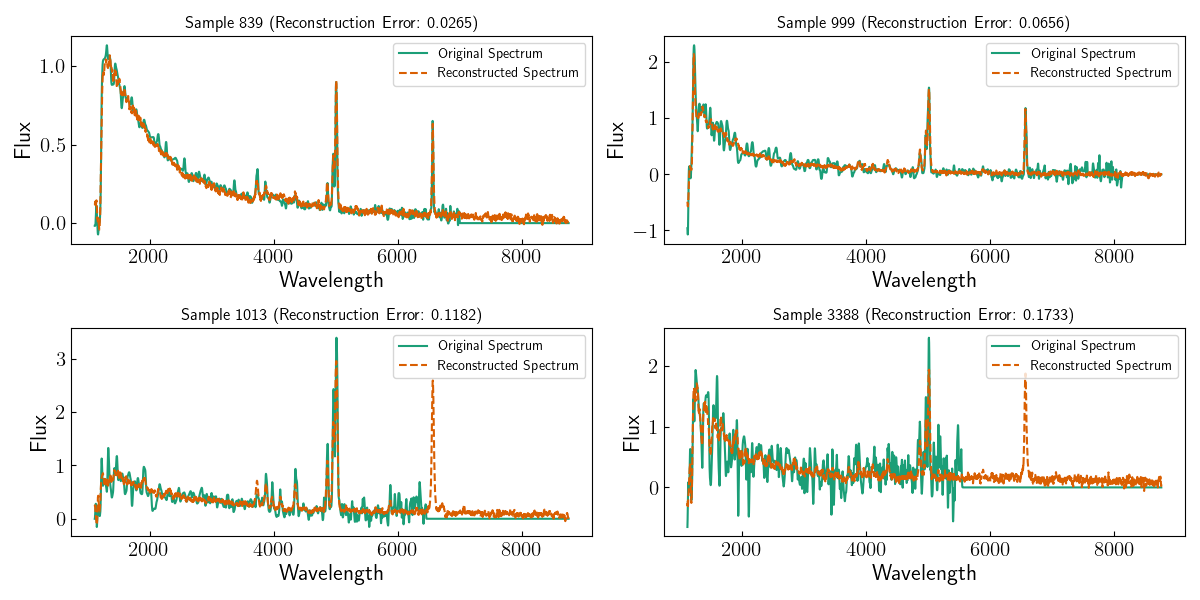

In [24]:
### Create a gallery of four reconstructed spectra, randomly sampled from four quantiles of the reconstruction error distribution
quantiles = np.percentile(reconstruction_errors, [0, 25, 50, 75, 100])
sample_indices = []
for i in range(len(quantiles) - 1):
    lower_bound = quantiles[i]
    upper_bound = quantiles[i + 1]
    indices = np.where((reconstruction_errors >= lower_bound) & (reconstruction_errors < upper_bound))[0]
    if len(indices) > 0:
        sample_indices.append(np.random.choice(indices))
    else:
        sample_indices.append(np.random.choice(len(resampled_data)))
print(f"Sample indices: {sample_indices}")
print(f"Reconstruction errors: {reconstruction_errors[sample_indices]}")
# Plot original vs reconstructed spectra for the selected indices
plt.close()
plt.figure(figsize=(12, 6))
for i, sample_idx in enumerate(sample_indices):
    plt.subplot(2, 2, i + 1)
    plt.plot(wavelength, resampled_data[sample_idx], label="Original Spectrum")
    plt.plot(wavelength, reconstructed_spectra[sample_idx], label="Reconstructed Spectrum", linestyle="--")
    plt.title(f"Sample {sample_idx} (Reconstruction Error: {reconstruction_errors[sample_idx]:.4f})")
    plt.xlabel("Wavelength")
    plt.ylabel("Flux")
    plt.legend()
plt.tight_layout()

# plt.savefig("reconstructed_spectra_gallery.png", dpi=300)
plt.show()

## Clustering!

In [25]:
### Perform clustering in latent space
import hdbscan
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score


### Use HDBSCAN on the latent space
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=2)
cluster_labels = clusterer.fit_predict(z_mean, z_log_var)  # shape (n_samples, 16)

### Use GMM
# gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
# cluster_labels = gmm.fit_predict(z_mean)

### Use the silhouette score to evaluate the clustering
silhouette_avg = silhouette_score(z_mean, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")
print(f"Number of clusters: {len(np.unique(cluster_labels))}")

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score: -0.15391787886619568
Number of clusters: 3


In [26]:
### First reduce dimensionality of the latent space using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
z_2d = umap_model.fit_transform(z_mean)

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [168]:
### Benchmarking various clustering algorithms
def benchmark_clustering(X, name="Latent space"):
    results = {}

    # K-Means
    kmeans = KMeans(n_clusters=5, random_state=42)
    labels_kmeans = kmeans.fit_predict(X)
    results['KMeans'] = labels_kmeans

    # GMM
    gmm = GaussianMixture(n_components=5, random_state=42)
    labels_gmm = gmm.fit_predict(X)
    results['GMM'] = labels_gmm

    # DBSCAN
    dbscan = DBSCAN(eps=1.0, min_samples=5)
    labels_dbscan = dbscan.fit_predict(X)
    results['DBSCAN'] = labels_dbscan

    # HDBSCAN (optional)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels_hdb = clusterer.fit_predict(X)
    results['HDBSCAN'] = labels_hdb

    print(f"\n📊 Clustering results for {name}:")
    for method, labels in results.items():
        mask = labels != -1  # Ignore noise for DBSCAN/HDBSCAN
        if len(set(labels[mask])) < 2:
            print(f"{method}: Too few clusters")
            continue
        silhouette = silhouette_score(X[mask], labels[mask])
        db_score = davies_bouldin_score(X[mask], labels[mask])
        print(f"{method}: Silhouette = {silhouette:.3f}, DB = {db_score:.3f}")

    # Optionally visualize
    plt.close()
    for method, labels in results.items():
        plt.figure(figsize=(5, 4))
        plt.title(f"{name} - {method}")
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=5)
        plt.colorbar(label='Cluster ID')
        plt.tight_layout()
        plt.show()

    return results



/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📊 Clustering results for Latent space (16D):
KMeans: Silhouette = 0.174, DB = 2.232
GMM: Silhouette = -0.114, DB = 5.169
DBSCAN: Silhouette = 0.130, DB = 0.987
HDBSCAN: Silhouette = 0.164, DB = 0.943


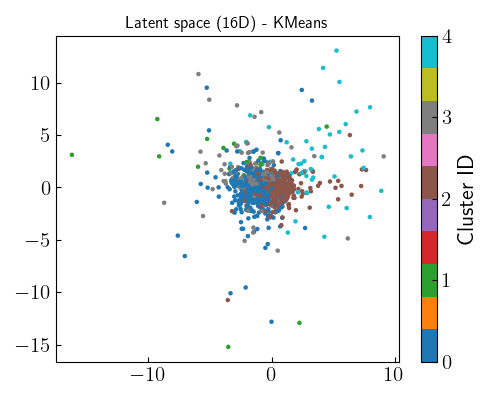

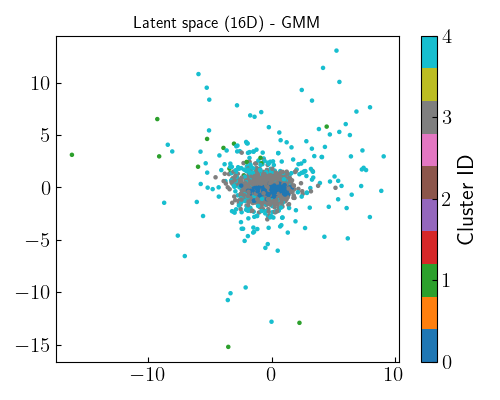

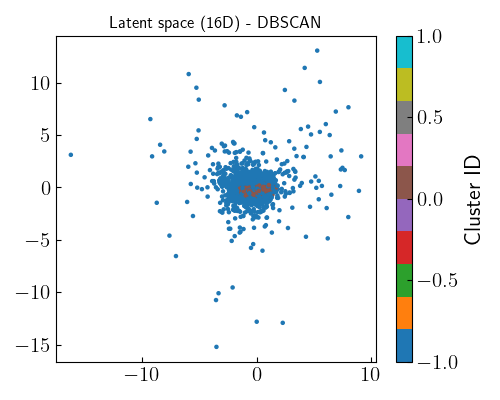

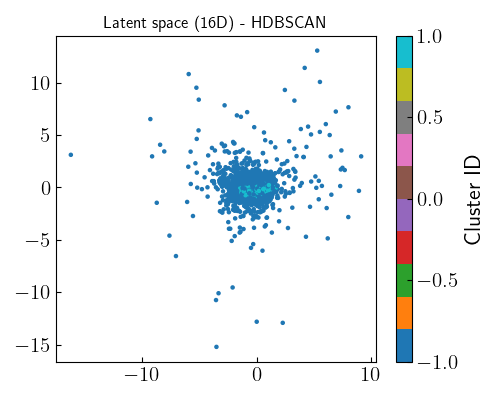

In [195]:
### Benchmark in UMAP space
# results_umap = benchmark_clustering(z_2d, name="UMAP projection")

### Benchmark in latent space
results_latent = benchmark_clustering(z_mean, name="Latent space (16D)")

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


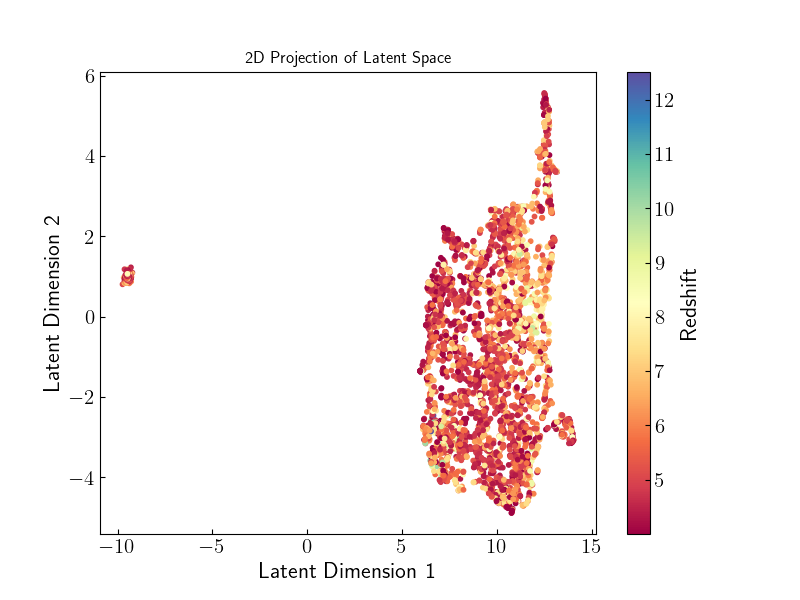

In [27]:
# Use UMAP to reduce the latent space to 2D
umap_model = umap.UMAP(n_neighbors=5, min_dist=0., metric='euclidean')
z_2d = umap_model.fit_transform(z_mean)

# Plot the 2D latent space
plt.close()
plt.figure(figsize=(8, 6))
# plt.scatter(z_2d[:, 0], z_2d[:, 1], c=np.arange(len(z_2d)), cmap='Spectral', s=10)
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=redshifts, cmap='Spectral', s=10)
plt.colorbar(label="Redshift")
plt.title("2D Projection of Latent Space")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


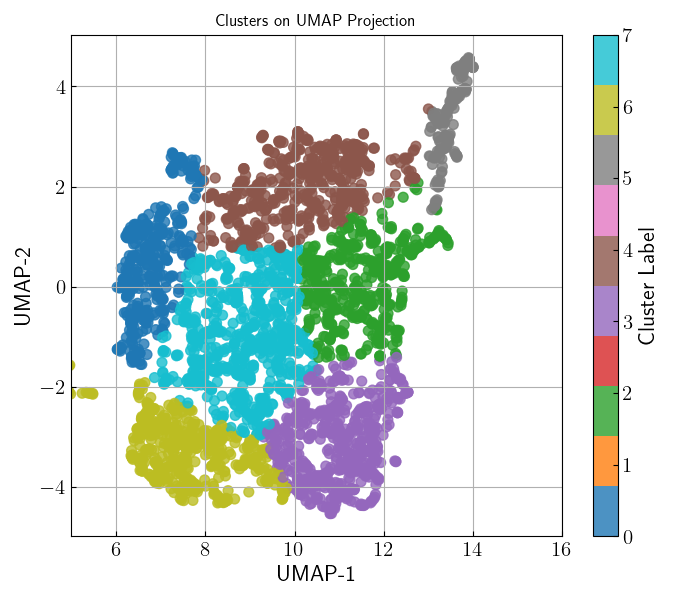

In [28]:
### Let's perfomr some clustering on the UMAP output using HDBSCAN
# umap_embedding: shape (n_samples, 2), from earlier
umap_embedding = umap_model.fit_transform(z_mean)

### Use HDBSCAN to cluster the UMAP output
# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10, metric='euclidean')
# cluster_labels = clusterer.fit_predict(umap_embedding)

### Use GMM instead
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(umap_embedding)

# Plotting
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],
            c=cluster_labels, cmap='tab10', s=50, alpha=0.8)
plt.title('Clusters on UMAP Projection')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.xlim(5,16)
plt.tight_layout()
plt.show()

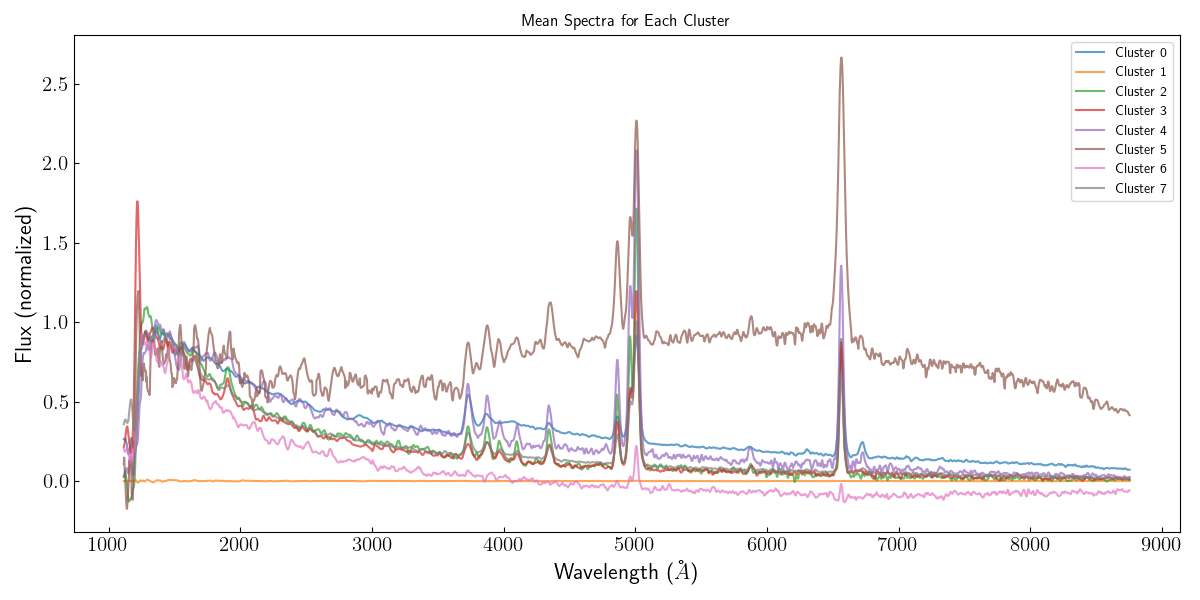

In [38]:
### Let's produce a mean spectrum per cluster
unique_labels = np.unique(cluster_labels)
# n_clusters = len(unique_labels[unique_labels != -1])  # excluding noise if any
n_clusters = len(unique_labels)

plt.close()
plt.figure(figsize=(12, 6))

for i, label in enumerate(unique_labels):
    # if label == -1:
    #     continue  # skip noise
    cluster_spectra = resampled_data[cluster_labels == label]
    mean_spectrum = np.mean(cluster_spectra, axis=0)
    ### Give the same color to the cluster
    color = sns.color_palette("tab10", n_colors=n_clusters)[i]
    plt.plot(wavelength, mean_spectrum, label=f'Cluster {label}', color=color, alpha=0.7)

plt.title("Mean Spectra for Each Cluster")
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux (normalized)")

# plt.yscale('log')
# plt.ylim(5e5, 1e8)
# plt.ylim(-10,10)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
### Print the number of sources in each cluster
for label in unique_labels:
    n_sources = np.sum(cluster_labels == label)
    print(f"Cluster {label}: {n_sources} sources")

Cluster 0: 410 sources
Cluster 1: 182 sources
Cluster 2: 485 sources
Cluster 3: 606 sources
Cluster 4: 557 sources
Cluster 5: 177 sources
Cluster 6: 622 sources
Cluster 7: 712 sources


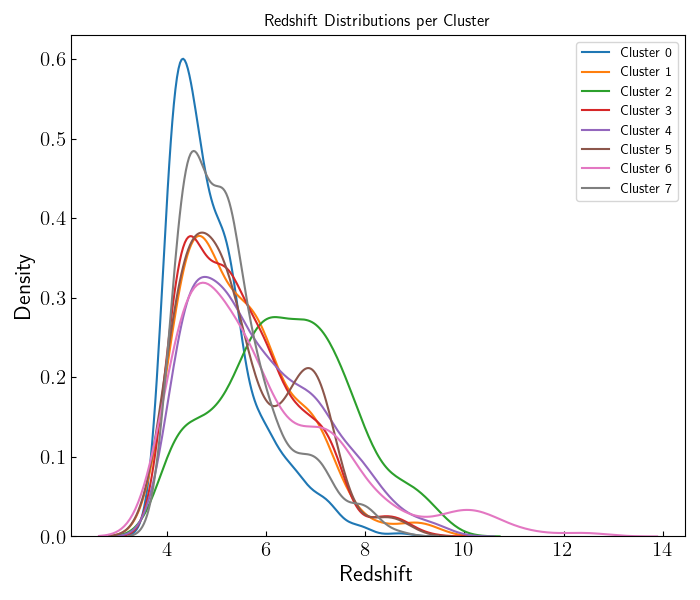

In [39]:
### Redshift distribution per cluster
plt.close()
plt.figure(figsize=(7, 6))
for i, label in enumerate(unique_labels):
    # if label == -1:
    #     continue
    color = sns.color_palette("tab10", n_colors=n_clusters)[i]
    z_vals = redshifts[cluster_labels == label]
    sns.kdeplot(z_vals, color=color, label=f"Cluster {label}")

plt.title("Redshift Distributions per Cluster")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/sv/jx060lhd70z6wbjpbh0tbbrr0000gt/T/ipykernel_7315/537901987.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


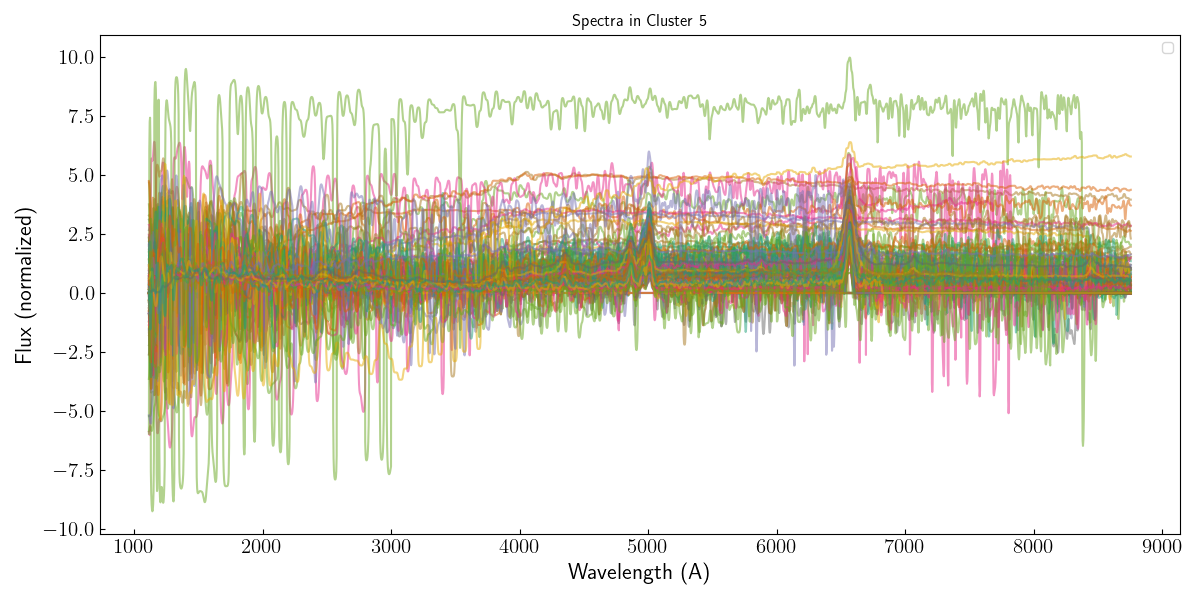

In [40]:
### Let us now analyze the actual input spectra in each cluster
def plot_cluster_spectra(cluster_label, cluster_spectra, wavelength, redshifts):
    plt.close()
    plt.figure(figsize=(12, 6))
    for i, spectrum in enumerate(cluster_spectra):
        plt.plot(wavelength, spectrum, alpha=0.5)
    plt.title(f"Spectra in Cluster {cluster_label}")
    plt.xlabel("Wavelength (A)")
    plt.ylabel("Flux (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot spectra for cluster 5
cluster_label = 5
cluster_spectra = resampled_data[cluster_labels == cluster_label]
plot_cluster_spectra(cluster_label, cluster_spectra, wavelength, redshifts[cluster_labels == cluster_label])


## Tests for optimal parameter choices for the VAE pipeline

In [ ]:
### Plot reconstriction losses vs number of latent dimensions
losses = np.array([final_loss_4dim, final_loss_8dim, final_loss_16dim, final_loss_32dim])
latent_dimensions = np.array([4, 8, 16, 32])
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(latent_dimensions, losses, marker='o', s=300, ec='k', zorder=10)
plt.axhline(y=np.min(losses), color='grey', linestyle='--')
plt.xlabel("Latent Dimensions")
plt.ylabel("Reconstruction Loss")
# plt.title("Reconstruction Loss vs Latent Dimensions")
# plt.xscale('log')
# plt.yscale('log')
plt.xticks(latent_dimensions)
# plt.yticks([10, 100, 300])
# plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_loss_vs_latent_dimensions.png", dpi=300)
plt.show()

In [ ]:
### Start by exploring KL losses per latent dimension
kl_per_dim_16 = np.mean(z_log_var - tf.math.log(tf.exp(z_log_var) + 1), axis=0)
print("KL losses per dimension: ", kl_per_dim_16)